### Install Required Packages

In [1]:
# !pip install -q py_dreambooth --user

In [2]:
# pip install diffusers["torch"] transformers

In [3]:
# pip install tensorflow transformers datasets diffusers

In [4]:
# pip install diffusers==0.24.0

In [5]:
# %pip install --upgrade diffusers[torch] -q

In [6]:
# pip install huggingface_hub

In [7]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


### Load Pacakges

In [8]:
# from py_dreambooth.dataset import LocalDataset
# from py_dreambooth.model import SdDreamboothModel
# from py_dreambooth.predictor import LocalPredictor
# from py_dreambooth.trainer import LocalTrainer
# from py_dreambooth.utils.image_helpers import display_images
# from py_dreambooth.utils.prompt_helpers import make_prompt

In [9]:
from diffusers import DiffusionPipeline, AutoencoderKL#, DreamBoothPipeline
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1+cpu)
    Python  3.9.13 (you have 3.9.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Collect and Prepare Data

In [10]:
# Define data directory
data_dir = r'C:\Users\samue\Desktop\Betty\2024 Summer Practicum\data'

List of filters available for kitchen cabinets:
- Cabinet Type: Wall, Base, Pantry, Sink Base, Bath, Corner, Double Oven, Single Oven, Wall Bridge, Drawer Base, Trash Can, Pull Out Pantry, Bar, Specialty Wall, Corner Standard, Corner Blind, Corner Diagonal, Corner Lazy Susan
- Corner Cabinet Type: Blind, Diagonal, Standard, Lazy Susan, Swinging Pullout
- Color Family: while, gray, brown, espresso, off white, black, blue, green, beige, red, unfinished, maple, multi-colored, red oak, unfinished wood

In [11]:
# Define keywords for kitchen cabinets
keywords = ["kitchen", 'cabinet', 'bath', 'corner', 'standard']

In [12]:
# Get list of image files that match the keywords
image_files = [f for f in os.listdir(data_dir) 
               if any(keyword in f for keyword in keywords) 
               and f.endswith('.png')]

# Define a transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming icons are grayscale
])

In [13]:
# Function to extract annotation from filename
def extract_annotation(filename):
    return filename.replace('_', ' ').replace('.png', '')

class KitchenCabinetDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(data_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        annotation = extract_annotation(img_name)
        return image, annotation

In [14]:
# Create dataset
dataset = KitchenCabinetDataset(image_files, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Inspect the dataset to ensure everything is loaded correctly

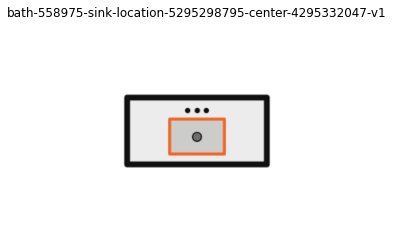

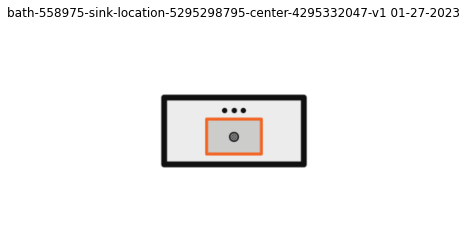

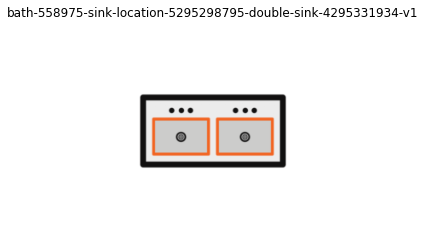

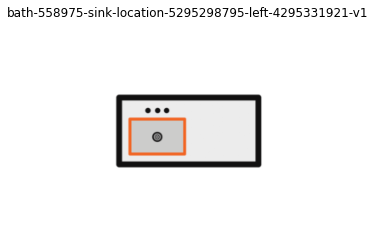

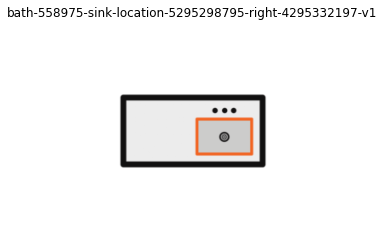

In [15]:
# Function to display an image and its annotation
def show_image(image, annotation):
    image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
    plt.imshow(image)
    plt.title(annotation)
    plt.axis('off')
    plt.show()

# Display a few images and their annotations
for i in range(5):
    image, annotation = dataset[i]
    show_image(image, annotation)

### Train the Model

In [16]:
# !pip install --upgrade diffusers transformers scipy --user

In [17]:
# pip install pytorch-transformers

In [18]:
from diffusers import StableDiffusionPipeline
import transformers

In [19]:
# !huggingface-cli login

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [21]:
# Check if CUDA is available
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [22]:
# pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# print(pipeline)

In [23]:
# Load the pre-trained Stable Diffusion model
model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
# Since we're running on CPU, let's limit the batch size and epochs for practical purposes
num_epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(num_epochs):
    for images, annotations in dataloader:
        images = images.to(device)
        # Simulated forward pass and compute loss (adjust based on your actual model's requirements)
        outputs = model(images, annotations)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

AttributeError: 'StableDiffusionPipeline' object has no attribute 'parameters'

In [26]:
# Example text prompts for generating new icons
text_prompts = ["Wall cabinet, white", "Corner Lazy Susan, maple", "Base cabinet, brown"]

In [25]:
generated_images = model(text_prompts)

# Display generated images
for img in generated_images:
    img.show()

  0%|          | 0/50 [00:00<?, ?it/s]


KeyboardInterrupt



In [28]:
from torch import autocast

model.enable_attention_slicing()
with autocast("cuda"):
    image = model(text_prompts).images[0]  

C:\Users\samue\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 